In [1]:
import os 
import gemmi
import numpy as np

def find_closest_residue(input_residue, target_structure, ns, search_dist=3):
    # Function to get the closest residue in a structure in terms of euclidean distance
    # closest residue is defined as the residue with the closest C-alpha atom
    #ns = gemmi.NeighborSearch(target_structure[0], target_structure.cell, search_dist).populate()
    amino_acids = ['ASN', 'SER', 'GLY', 'ILE', 'MET', 'PHE', 'ASP', 'GLU', 'ARG', 'TRP', 'LYS', 'ALA', 'GLN', 'VAL', 'LEU', 'TYR', 'THR', 'CYS', 'HIS', 'PRO']
    nucleic_acids = ['A', 'C', 'G', 'U', 'DA', 'DC', 'DG', 'DT']
    
    if input_residue.name in amino_acids:
        input_residue_ca = input_residue.find_atom('CA', '*')
        if input_residue_ca is None:
            return "NO_CA_ATOM"
        input_residue_pos = input_residue_ca.pos
    elif input_residue.name in nucleic_acids:
        input_residue_P = input_residue.find_atom('P', '*')
        if input_residue_P is None:
            return "NO_P_ATOM"
        input_residue_pos = input_residue_P.pos
    
    neighbors = ns.find_atoms(input_residue_pos, '\0', search_dist)
    if len(neighbors) == 0:
        return "NO_NEIGHBORS"
    else:
        # find the closes C-alpha atom
        closest_ca_atom = None
        all_ca_atoms = []
        ca_dist = []
        for neighbor in neighbors:
            atom = neighbor.to_cra(target_structure[0]).atom
            if atom.name == 'CA':
                all_ca_atoms.append(neighbor)
                ca_dist.append(atom.pos.dist(input_residue_pos))
        if len(all_ca_atoms) == 0:
            return "NO_CA_NEIGHBORS"
        else:
            closest_ca_atom = all_ca_atoms[np.argmin(ca_dist)]
            closest_residue = target_structure[0][closest_ca_atom.chain_idx][closest_ca_atom.residue_idx]
            return closest_residue

In [2]:
def get_all_residues(structure):
    residue_list = []
    for chain in structure[0]:
        chain_name = chain.name
        for residue in chain:
            residue_list.append(residue)
    return residue_list, chain_name

In [3]:
amino_acids = ['ASN', 'SER', 'GLY', 'ILE', 'MET', 'PHE', 'ASP', 'GLU', 'ARG', 'TRP', 'LYS', 'ALA', 'GLN', 'VAL', 'LEU', 'TYR', 'THR', 'CYS', 'HIS', 'PRO']
nucleic_acids = ['A', 'C', 'G', 'U', 'DA', 'DC', 'DG', 'DT']
def filter_residue_sequence(residue_sequence):
    filtered = [x for x in residue_sequence if x.name in amino_acids or x.name in nucleic_acids]
    return filtered
    
        
        

In [4]:
emdb_pdb = "0071_6gve"

emdb, pdb = emdb_pdb.split("_")
pdb_path_1 = f"/home/abharadwaj1/papers/elife_paper/figure_information/data/model_angelo_predictions_new_version/{emdb_pdb}/emd_{emdb}_model_angelo_unsharpened/emd_{emdb}_model_angelo_unsharpened.cif"
pdb_path_2 = f"/home/abharadwaj1/papers/elife_paper/figure_information/data/model_angelo_predictions_new_version/{emdb_pdb}/emd_{emdb}_model_angelo_hybrid/emd_{emdb}_model_angelo_hybrid.cif"
pdb_deposited = f"/home/abharadwaj1/papers/elife_paper/figure_information/data/deposited_atomic_models/PDB_{pdb}_unrefined_shifted_servalcat_refined_shifted_servalcat_refined.pdb"
search_radius=3

# Load the reference structure
cif_st_1 = gemmi.read_structure(pdb_path_1)
cif_st_2 = gemmi.read_structure(pdb_path_2)

locscale_gt_unsharpened = len(get_all_residues(cif_st_1)[0]) < len(get_all_residues(cif_st_2)[0])

print(f"LocScale residues more than unsharpened: {locscale_gt_unsharpened}")


# save the structures as pdb files
pdb_save_path_1 = f"/home/abharadwaj1/papers/elife_paper/figure_information/data/model_angelo_predictions_new_version/{emdb_pdb}/emd_{emdb}_model_angelo_unsharpened/emd_{emdb}_model_angelo_unsharpened.pdb"
pdb_save_path_2 = f"/home/abharadwaj1/papers/elife_paper/figure_information/data/model_angelo_predictions_new_version/{emdb_pdb}/emd_{emdb}_model_angelo_hybrid/emd_{emdb}_model_angelo_hybrid.pdb"
cif_st_1.write_pdb(pdb_save_path_1)
cif_st_2.write_pdb(pdb_save_path_2)

if locscale_gt_unsharpened:
    st_1 = gemmi.read_structure(pdb_save_path_1)
    st_2 = gemmi.read_structure(pdb_save_path_2)
else:
    st_1 = gemmi.read_structure(pdb_save_path_2)
    st_2 = gemmi.read_structure(pdb_save_path_1)

st_ref = gemmi.read_structure(pdb_deposited)

residues_1, chain_names_1 = get_all_residues(st_1)
residues_2, chain_names_2 = get_all_residues(st_2)


amino_acids = ['ASN', 'SER', 'GLY', 'ILE', 'MET', 'PHE', 'ASP', 'GLU', 'ARG', 'TRP', 'LYS', 'ALA', 'GLN', 'VAL', 'LEU', 'TYR', 'THR', 'CYS', 'HIS', 'PRO']
nucleic_acids = ['A', 'C', 'G', 'U', 'DA', 'DC', 'DG', 'DT']
filtered_residues_target = [residue for residue in residues_2 if residue.name in amino_acids or residue.name in nucleic_acids]
amino_acids_residue_names = [residue.name for residue in filtered_residues_target if residue.name in amino_acids]
nucleic_acids_residue_names = [residue.name for residue in filtered_residues_target if residue.name in nucleic_acids]

print("Number of amino acids in the target structure: ", len(amino_acids_residue_names))
print("Number of nucleic acids in the target structure: ", len(nucleic_acids_residue_names))

ns = gemmi.NeighborSearch(st_1[0], st_1.cell, search_radius).populate()
ns_ref = gemmi.NeighborSearch(st_ref[0], st_ref.cell, search_radius).populate()

#extra_residues = [find_closest_residue(target_residue, st_1, ns) for target_residue in filtered_residues_target]
closest_residues = []
no_ca_atoms = []
no_ca_neighbors = []
no_neighbors = []

for res in filtered_residues_target:
    closest_residue = find_closest_residue(res, st_1, ns, search_radius)
    if isinstance(closest_residue, str):
        if closest_residue == "NO_CA_ATOM":
            no_ca_atoms.append(res)
        elif closest_residue == "NO_NEIGHBORS":
            no_neighbors.append(res)
        elif closest_residue == "NO_CA_NEIGHBORS":
            no_ca_neighbors.append(res)
        else:
            print("ERROR")
    else:
        closest_residues.append(closest_residue)
    


LocScale residues more than unsharpened: True
Number of amino acids in the target structure:  2677
Number of nucleic acids in the target structure:  0


In [5]:
print("Number of residues with no CA atoms: ", len(no_ca_atoms))
print("Number of residues with no neighbors: ", len(no_neighbors))
print("Number of residues with no CA neighbors: ", len(no_ca_neighbors))
print("Number of residues with closest residues: ", len(closest_residues))
print("Total number of residues: ", len(filtered_residues_target))
print("Number of residues in structure 1: ", len(residues_1))
print("Number of residues in structure 2: ", len(residues_2))
print("Expected difference in number of residues: ", len(residues_2) - len(residues_1))


Number of residues with no CA atoms:  0
Number of residues with no neighbors:  1209
Number of residues with no CA neighbors:  183
Number of residues with closest residues:  1285
Total number of residues:  2677
Number of residues in structure 1:  1463
Number of residues in structure 2:  2677
Expected difference in number of residues:  1214


In [6]:
extra_residues = [x for x in no_neighbors]

fragment_lengths = []
fragment = []
all_fragments = []
expanded_ref_residues = []

for res in extra_residues:
    seqid = res.seqid.num
    if len(fragment) == 0:
        fragment.append(res)
    else:
        # if there is a gap in the sequence, then start a new fragment
        gap_in_sequence = abs(seqid - fragment[-1].seqid.num) > 1
        ca_atom = res.find_atom("CA","*")
        ca_last_atom = fragment[-1].find_atom("CA", "*")
        
        if ca_atom is None or ca_last_atom is None:
            assert False, "CA atom not found"
        
        ca_atom_pos = np.array(ca_atom.pos.tolist())
        ca_last_atom_pos = np.array(ca_last_atom.pos.tolist())
        
        distance = np.linalg.norm(ca_atom_pos - ca_last_atom_pos)
        
        large_gap_in_distance = distance > 4

        if gap_in_sequence or large_gap_in_distance:
            fragment_lengths.append(len(fragment))
            all_fragments.append(fragment)
            fragment = []
        fragment.append(res)    

In [7]:
def find_residue_in_sequence(residue_sequence, target_residue):
    for i,res in enumerate(residue_sequence):
        name_match = res.name == target_residue.name
        ca_target = target_residue.find_atom("CA", "*") 
        ca_res = res.find_atom("CA", "*")
        if ca_target is None or ca_res is None:
            continue
        ca_pos_match = ca_target.pos.tolist() == ca_res.pos.tolist()
        
        if name_match and ca_pos_match:
            return i
    return False


In [8]:
all_reference_residues, chain_names_ref = get_all_residues(st_ref)
extended_fragment_in_reference_sequence = {}
fragment_start_end_indices = {}
for i, fragment in enumerate(all_fragments):
    ref_fragment = []
    for res in fragment:
        ref_residue = find_closest_residue(res, st_ref, ns_ref, search_radius)
        if not isinstance(ref_residue, gemmi.Residue):
            break
        ref_fragment.append(ref_residue)
    
    if len(ref_fragment) != len(fragment):
        print(i, "Lengths of fragment and reference fragment do not match, fragment: ", len(fragment), " reference fragment: ", len(ref_fragment))
        continue
            
    first_residue_index_in_sequence = find_residue_in_sequence(all_reference_residues, ref_fragment[0])
    last_residue_index_in_sequence = find_residue_in_sequence(all_reference_residues, ref_fragment[-1])
        
    reached_left_end = False
    reached_right_end = False
    start_index = first_residue_index_in_sequence
    left_residues_added = 0
    while not reached_left_end:
        residue_to_the_left_of_ref_residue = all_reference_residues[start_index - 1]
        difference_in_residue_seq = abs(residue_to_the_left_of_ref_residue.seqid.num -  ref_residue.seqid.num)
        chain_name_continuous = residue_to_the_left_of_ref_residue.subchain == ref_residue.subchain
        if difference_in_residue_seq > 1 and chain_name_continuous:
            reached_left_end = True
            
        # append the residue to the left of the reference residue
        ref_fragment.insert(0, residue_to_the_left_of_ref_residue)
        left_residues_added += 1
        start_index -= 1
        if start_index - 1 < 0:
            reached_left_end = True
            
        if len(ref_fragment) > len(all_reference_residues):
            print("ERROR", len(ref_fragment), len(all_reference_residues))
            raise Exception("ERROR")
            
    start_index = last_residue_index_in_sequence
    right_residues_added = 0
    while not reached_right_end:
        residue_to_the_right_of_ref_residue = all_reference_residues[start_index + 1]
        difference_in_residue_seq = abs(residue_to_the_right_of_ref_residue.seqid.num -  ref_residue.seqid.num)
        chain_name_continuous = residue_to_the_right_of_ref_residue.subchain == ref_residue.subchain
        if difference_in_residue_seq > 1 and chain_name_continuous:
            reached_right_end = True
        # append the residue to the right of the reference residue
        ref_fragment.append(residue_to_the_right_of_ref_residue)
        right_residues_added += 1
        
        start_index += 1
        
        if start_index + 1 > len(all_reference_residues) - 1:
            reached_right_end = True
        
        if len(ref_fragment) > len(all_reference_residues):
            print("ERROR", len(ref_fragment), len(all_reference_residues))
            raise Exception("ERROR")
        
    extended_fragment_in_reference_sequence[i] = ref_fragment
    fragment_start_end_indices[i] = (left_residues_added, right_residues_added)
    
    print(f"{i}\t {len(fragment)}\t {len(ref_fragment)} \t {left_residues_added} \t {right_residues_added}")

0	 10	 13 	 1 	 2
1	 2	 5 	 1 	 2
2	 7	 10 	 1 	 2
3	 1	 5 	 2 	 2
4	 4	 7 	 1 	 2
5	 3	 6 	 1 	 2
6	 1	 5 	 2 	 2
7	 3	 6 	 1 	 2
8	 4	 7 	 1 	 2
9	 5	 8 	 1 	 2
10	 1	 5 	 2 	 2
11	 20	 23 	 1 	 2
12	 1	 5 	 2 	 2
13	 4	 7 	 1 	 2
14	 6	 9 	 1 	 2
15	 6	 9 	 1 	 2
16	 13	 16 	 1 	 2
17	 1	 5 	 2 	 2
18	 8	 11 	 1 	 2
19	 6	 9 	 1 	 2
20	 13	 16 	 1 	 2
21	 12	 15 	 1 	 2
22	 4	 7 	 1 	 2
23	 1	 5 	 2 	 2
24	 6	 9 	 1 	 2
25	 6	 9 	 1 	 2
26	 2	 5 	 1 	 2
27 Lengths of fragment and reference fragment do not match, fragment:  5  reference fragment:  1
28	 4	 7 	 1 	 2
29	 23	 26 	 1 	 2
30	 1	 5 	 2 	 2
31	 3	 6 	 1 	 2
32	 6	 9 	 1 	 2
33	 1	 5 	 2 	 2
34	 1	 5 	 2 	 2
35	 1	 5 	 2 	 2
36 Lengths of fragment and reference fragment do not match, fragment:  5  reference fragment:  0
37	 1	 5 	 2 	 2
38	 1	 5 	 2 	 2
39	 3	 6 	 1 	 2
40	 15	 17 	 1 	 1
41	 1	 5 	 2 	 2
42	 2	 5 	 1 	 2
43	 12	 15 	 1 	 2
44	 1	 5 	 2 	 2
45	 3	 6 	 1 	 2
46	 7	 10 	 1 	 2
47	 1	 5 	 2 	 2
48	 3	 6 	 1 	 

In [9]:
print("Number of fragments: ", len(all_fragments))
num_residues_in_extended_fragments = sum([len(x) for x in extended_fragment_in_reference_sequence.values()])
print("Number of residues in extended fragments: ", num_residues_in_extended_fragments)
print("Number of residues in reference structure: ", len(all_reference_residues))

Number of fragments:  263
Number of residues in extended fragments:  1913
Number of residues in reference structure:  4280


Total number of fragments:  263


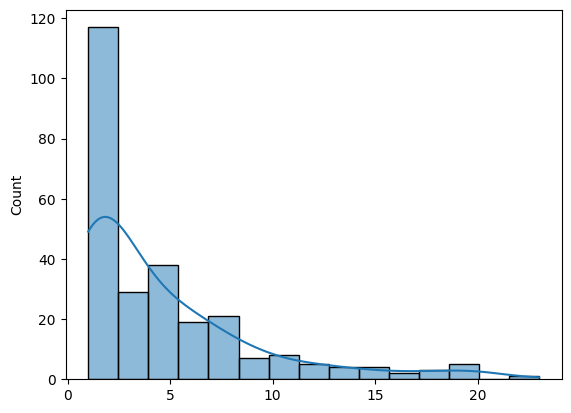

In [10]:
# plot the histogram of fragment lengths
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(fragment_lengths, kde=True)
print("Total number of fragments: ", len(fragment_lengths))

In [11]:
atom_positions_fragments = []
for fragment in all_fragments:
    for res in fragment:
        for atom in res:
            atom_positions_fragments.append(atom.pos.tolist())




In [12]:
found_atoms = 0
for chain in st_2[0]:
    for res in chain:
        for atom in res:
            if atom.pos.tolist() in atom_positions_fragments:
                atom.b_iso = 999
                found_atoms += 1
            else:
                atom.b_iso = 0
print("Number of atoms found: ", found_atoms)
print("Number of atoms in fragment: ", len(atom_positions_fragments))


Number of atoms found:  9354
Number of atoms in fragment:  9354


In [13]:
extracted_residue_path = pdb_path_2[:-4] + "_extracted_residues.pdb"
st_2.write_pdb(extracted_residue_path)

In [14]:
print(extracted_residue_path)

/home/abharadwaj1/papers/elife_paper/figure_information/data/model_angelo_predictions_new_version/0071_6gve/emd_0071_model_angelo_hybrid/emd_0071_model_angelo_hybrid_extracted_residues.pdb


In [15]:
# find the intensity distribution at the fragment positions
from locscale.include.emmer.ndimage.map_utils import read_gemmi_map, load_map, save_as_mrc
from locscale.include.emmer.ndimage.map_tools import apply_radial_profile
from locscale.emmernet.emmernet_functions import standardize_map

emmap_path_1 = f"/home/abharadwaj1/papers/elife_paper/figure_information/data/model_angelo_predictions_new_version/{emdb_pdb}/EMD_{int(emdb)}_unsharpened_fullmap.mrc"
emmap_path_2 = f"/home/abharadwaj1/papers/elife_paper/figure_information/data/model_angelo_predictions_new_version/{emdb_pdb}/emdb_{emdb}_hybrid_locscale_C_output.mrc"

emmap_1, apix = load_map(emmap_path_1)
emmap_2, apix = load_map(emmap_path_2)

emmap_1_standardized = apply_radial_profile(emmap_1, reference_map=emmap_2)
emmap_2_standardized = emmap_2

print(f"EMMAP1: {emmap_1_standardized.mean()}, {emmap_1_standardized.std()}")
print(f"EMMAP2: {emmap_2_standardized.mean()}, {emmap_2_standardized.std()}")

emmap_1_standardized_path = emmap_path_1.replace(".mrc", "_standardized.mrc")
emmap_2_standardized_path = emmap_path_2.replace(".mrc", "_standardized.mrc")

save_as_mrc(emmap_1_standardized, emmap_1_standardized_path, apix)
save_as_mrc(emmap_2_standardized, emmap_2_standardized_path, apix)

# standardise the grids 
_, grid_1 = read_gemmi_map(emmap_1_standardized_path, return_grid=True)
_, grid_2 = read_gemmi_map(emmap_2_standardized_path, return_grid=True)

EMMAP1: -0.0017815702379785777, 0.01653066785865089
EMMAP2: 0.0017815508181229234, 0.016961369663476944


In [16]:
# get the average noise level using mask 
mask_path = f"/home/abharadwaj1/papers/elife_paper/figure_information/data/confidence_masks/emd_{emdb}_FDR_confidence_final.map"
mask, apix = load_map(mask_path)

mask_binarise = (mask >= 0.99).astype(bool)

noise_intensities_1 = emmap_1_standardized[mask_binarise]
noise_intensities_2 = emmap_2_standardized[mask_binarise]

mean_noise_1, std_noise_1 = noise_intensities_1.mean(), noise_intensities_1.std()
mean_noise_2, std_noise_2 = noise_intensities_2.mean(), noise_intensities_2.std()

print(f"Mean noise 1: {mean_noise_1}, std noise 1: {std_noise_1}")
print(f"Mean noise 2: {mean_noise_2}, std noise 2: {std_noise_2}")

noise_max_level = mean_noise_1 + std_noise_1
noise_min_level = mean_noise_1 - std_noise_1
print(f"Noise max level: {noise_max_level}, noise min level: {noise_min_level}")

Mean noise 1: 0.08700936634431516, std noise 1: 0.06999842920759265
Mean noise 2: 0.09334917366504669, std noise 2: 0.08126693964004517
Noise max level: 0.1570077955519078, noise min level: 0.017010937136722512


In [17]:
intensities_at_each_fragment_for_emmap_1 = {}
intensities_at_each_fragment_for_emmap_2 = {}
for i, fragment in enumerate(all_fragments):
    intensities_at_fragment_1 = []
    intensities_at_fragment_2 = []
    if i not in extended_fragment_in_reference_sequence:
        continue
    reference_fragment = extended_fragment_in_reference_sequence[i]
    for res in reference_fragment:
        ca = res.find_atom("CA","*")
        if ca is None:
            continue
        ca_pos = ca.pos
        intensity_1 = grid_1.interpolate_value(ca_pos)
        intensity_2 = grid_2.interpolate_value(ca_pos)
        
        intensities_at_fragment_1.append(intensity_1)
        intensities_at_fragment_2.append(intensity_2)
    
    intensities_at_each_fragment_for_emmap_1[i] = intensities_at_fragment_1
    intensities_at_each_fragment_for_emmap_2[i] = intensities_at_fragment_2
    

In [18]:
for i in intensities_at_each_fragment_for_emmap_1:
    fragment_from_locscale_predicted_model = all_fragments[i]
    fragment_from_reference_model = extended_fragment_in_reference_sequence[i]
    
    # check if all atomic are close to each other in the two fragments    
    left_residues_in_fragment, right_residues_in_fragment = fragment_start_end_indices[i]
    for r, res in enumerate(fragment_from_reference_model[left_residues_in_fragment:right_residues_in_fragment]):
        ca_ref = res.find_atom("CA","*")
        ca_pred = fragment_from_locscale_predicted_model[r].find_atom("CA","*")
        if ca_ref is None or ca_pred is None:
            continue
        
        ca_ref_pos = np.array(ca_ref.pos.tolist())
        ca_pred_pos = np.array(ca_pred.pos.tolist())
        
        assert np.linalg.norm(ca_ref_pos - ca_pred_pos) < 3

In [19]:
for i, res_index in enumerate(range(len(residues_2)-1)):
    res_current = residues_2[res_index]
    res_next = residues_2[res_index+1]
    
    ca_res_current = res_current.find_atom("CA","*")
    ca_res_next = res_next.find_atom("CA","*")
    
    if ca_res_current is None or ca_res_next is None:
        continue
    
    ca_res_current_pos = np.array(ca_res_current.pos.tolist())
    ca_res_next_pos = np.array(ca_res_next.pos.tolist())
    
    dist = np.linalg.norm(ca_res_current_pos - ca_res_next_pos)
    
    print(i, dist)
    
    

0 3.771515743040199
1 3.887465112383635
2 3.748328294053233
3 3.655788423856059
4 3.777716373683986
5 3.749441958478634
6 3.7883629709942173
7 3.7274041905862454
8 3.826011761612855
9 3.646371346969467
10 3.690982660484881
11 3.852343832006695
12 3.8734389113551346
13 3.623036709722938
14 3.773840616666267
15 3.615027524099908
16 3.6499584929146773
17 5.198401004155037
18 3.5622108303692372
19 3.7365743669837435
20 3.7776930791158705
21 3.705026180744223
22 3.8523247526655835
23 3.783917018117595
24 3.8027145567344234
25 3.542231500057545
26 3.7412016786054005
27 3.598795770810018
28 3.7803636068505346
29 3.6129613892207453
30 3.6871739855884096
31 3.74451091599424
32 3.779337111187603
33 3.756715187500925
34 3.7143905287408745
35 3.7700049071585933
36 5.699003509386517
37 3.8629361889630163
38 3.8487043274328205
39 3.8285660501028427
40 3.74668573542006
41 3.7333268005895297
42 4.115903788962983
43 3.5662577024101876
44 3.7600655579391282
45 3.829627266458175
46 7.056785457982978
47 3

In [31]:
import random 
fragment_index = random.choice(list(intensities_at_each_fragment_for_emmap_1.keys()))
test_fragment = extended_fragment_in_reference_sequence[fragment_index]

for i in range(1, len(test_fragment)):
    ca_i = test_fragment[i].find_atom("CA","*")
    ca_i_minus_1 = test_fragment[i-1].find_atom("CA","*")
    
    ca_i_pos = np.array(ca_i.pos.tolist())
    ca_i_minus_1_pos = np.array(ca_i_minus_1.pos.tolist())
    
    print(np.linalg.norm(ca_i_pos - ca_i_minus_1_pos))
    

3.781957297485014
3.803560963097587
3.8044371462806263
3.7936069907147862


Number of atoms in fragment: 20


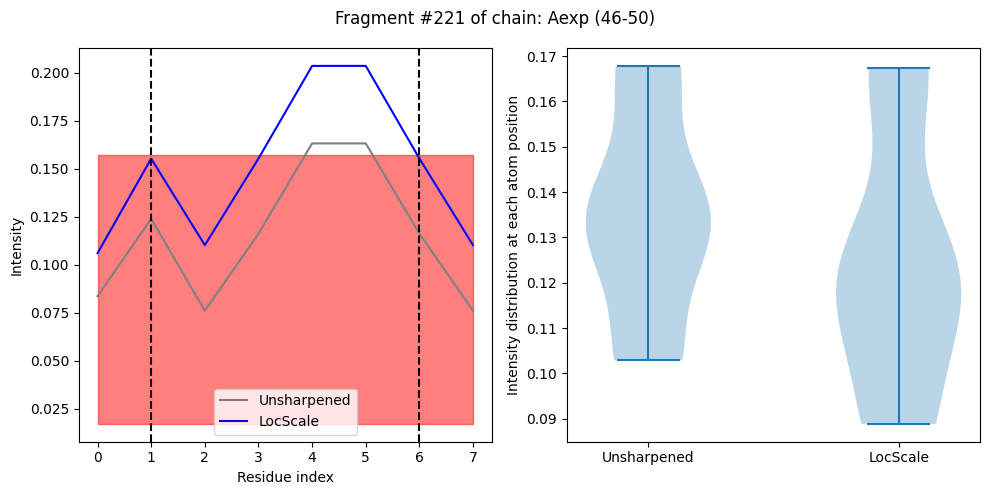

In [50]:
# plot the intensities for a random fragment
import random
fragment_index = random.choice(list(intensities_at_each_fragment_for_emmap_1.keys()))

test_fragment_1 = intensities_at_each_fragment_for_emmap_1[fragment_index]
test_fragment_2 = intensities_at_each_fragment_for_emmap_2[fragment_index]

fragment_start_index = all_fragments[fragment_index][0].seqid.num
fragment_end_index = all_fragments[fragment_index][-1].seqid.num
# x_axis = np.arange(fragment_start_index, fragment_end_index+1)
x_axis = np.arange(len(test_fragment_1))
num_residues_added_to_left = fragment_start_end_indices[fragment_index][0]
num_residues_added_to_right = fragment_start_end_indices[fragment_index][1]

chain_names = [res.subchain for res in all_fragments[fragment_index]]
#print(chain_names)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(x_axis, test_fragment_1, label="Unsharpened", color="grey")
ax[0].plot(x_axis, test_fragment_2, label="LocScale", color="blue")
ax[0].fill_between(x_axis, noise_min_level, noise_max_level, color="red", alpha=0.5)
title_text = f"Fragment #{fragment_index+1} of chain: {chain_names[0]} ({fragment_start_index}-{fragment_end_index})"
ax[0].set_xlabel("Residue index")
ax[0].set_ylabel("Intensity")
ax[0].legend()
# draw a vertical line at the start and end of the fragment
ax[0].axvline(x=num_residues_added_to_left, color="black", linestyle="--")
ax[0].axvline(x=len(test_fragment_1)-num_residues_added_to_right, color="black", linestyle="--")


# for the second plot we will plot histograms of the intensities at each atom position in the fragment
atom_intensities_1 = [grid_1.interpolate_value(atom.pos) for atom in res for res in all_fragments[fragment_index]]
atom_intensities_2 = [grid_2.interpolate_value(atom.pos) for atom in res for res in all_fragments[fragment_index]]
num_atoms = len(atom_intensities_1)
ax[1].violinplot([atom_intensities_1, atom_intensities_2])
ax[1].set_xticks([1, 2])
ax[1].set_xticklabels(["Unsharpened", "LocScale"])
ax[1].set_ylabel("Intensity distribution at each atom position")
print(f"Number of atoms in fragment: {num_atoms}")
fig.suptitle(title_text)

plt.tight_layout()


In [51]:
# plot intensity distributions for all fragments together 
# split by main chain and side chain

main_chain_intensities_1 = []
side_chain_intensities_1 = []
main_chain_intensities_2 = []
side_chain_intensities_2 = []
all_atom_intensities_1 = []
all_atom_intensities_2 = []
for fragment in all_fragments:
    for res in fragment:
        for atom in res: 
            intensity_1 = grid_1.interpolate_value(atom.pos)
            intensity_2 = grid_2.interpolate_value(atom.pos)
            
            all_atom_intensities_1.append(intensity_1)
            all_atom_intensities_2.append(intensity_2)
            
            if atom.name in ["N", "CA", "C", "O"]:
                main_chain_intensities_1.append(intensity_1)
                main_chain_intensities_2.append(intensity_2)
            else:
                side_chain_intensities_1.append(intensity_1)
                side_chain_intensities_2.append(intensity_2)

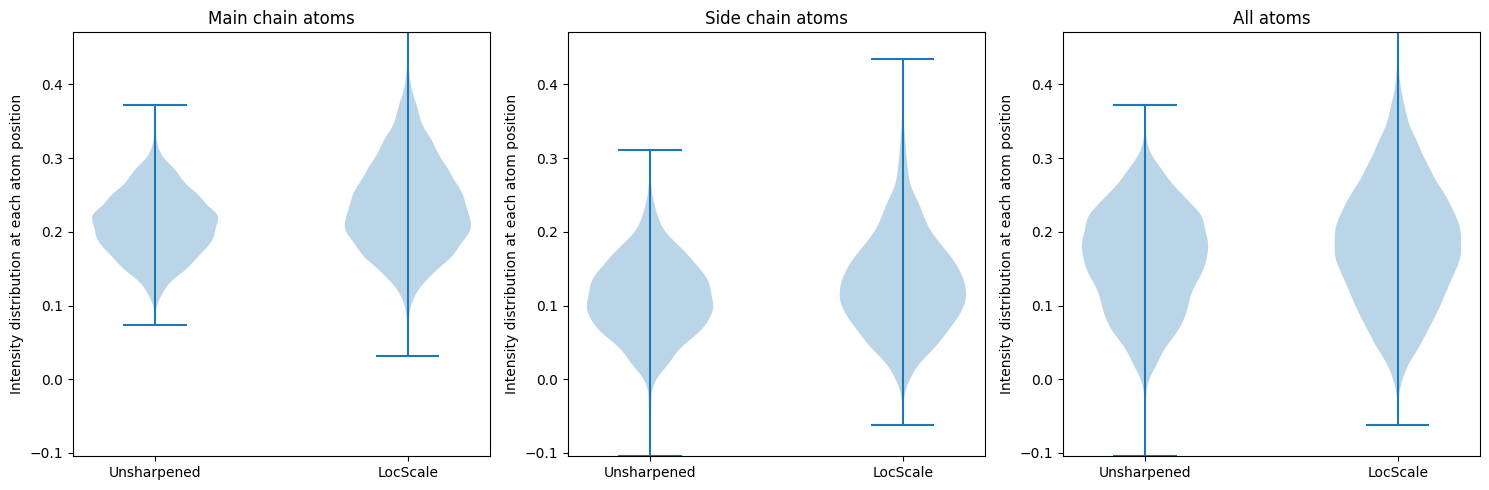

In [52]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
# in the first subplot plot the distribution of intensities for main chain atoms
# in the second subplot plot the distribution of intensities for side chain atoms

ax[0].violinplot([main_chain_intensities_1, main_chain_intensities_2])
ax[0].set_xticks([1, 2])
ax[0].set_xticklabels(["Unsharpened", "LocScale"])
ax[0].set_ylabel("Intensity distribution at each atom position")
ax[0].set_title("Main chain atoms")
y_lim_min = min(min(main_chain_intensities_1), min(main_chain_intensities_2), min(side_chain_intensities_1), min(side_chain_intensities_2))
y_lim_max = max(max(main_chain_intensities_1), max(main_chain_intensities_2), max(side_chain_intensities_1), max(side_chain_intensities_2))
ax[0].set_ylim(y_lim_min, y_lim_max)

ax[1].violinplot([side_chain_intensities_1, side_chain_intensities_2])
ax[1].set_xticks([1, 2])
ax[1].set_xticklabels(["Unsharpened", "LocScale"])
ax[1].set_ylabel("Intensity distribution at each atom position")
ax[1].set_title("Side chain atoms")
ax[1].set_ylim(y_lim_min, y_lim_max)

ax[2].violinplot([all_atom_intensities_1, all_atom_intensities_2])
ax[2].set_xticks([1, 2])
ax[2].set_xticklabels(["Unsharpened", "LocScale"])
ax[2].set_ylabel("Intensity distribution at each atom position")
ax[2].set_title("All atoms")
ax[2].set_ylim(y_lim_min, y_lim_max)

plt.tight_layout()



In [53]:
# statistical significance of the difference between the two distributions
def get_significance_permutation_test(array_1, array_2):
    from scipy.stats import permutation_test
    def statistic(array_1, array_2):
        return np.mean(array_1) - np.mean(array_2)
    
    result = permutation_test((array_1, array_2), statistic=statistic, n_resamples=10000)
    print(f"p-value: {result.pvalue}")
    print(f"observed statistic: {result.statistic}")
    return result


In [54]:
import shutil

output_folder = "/tudelft/abharadwaj1/staff-umbrella/ajlab/AB/PhD_research/cryo_em_map_sharpening/papers_and_conference/elife_paper/temporary_analysis_folder/model_angelo_analysis/test_extra_residue_intensity"
output_folder_emdb = os.path.join(output_folder, f"{emdb_pdb}")
if not os.path.exists(output_folder_emdb):
    os.mkdir(output_folder_emdb)

# copy the pdb file to the output folder
shutil.copyfile(pdb_save_path_1, os.path.join(output_folder_emdb, os.path.basename(pdb_save_path_1)))
shutil.copyfile(pdb_save_path_2, os.path.join(output_folder_emdb, os.path.basename(pdb_save_path_2)))
shutil.copyfile(emmap_1_standardized_path, os.path.join(output_folder_emdb, os.path.basename(emmap_1_standardized_path)))
shutil.copyfile(emmap_2_standardized_path, os.path.join(output_folder_emdb, os.path.basename(emmap_2_standardized_path)))

print("All files copied to output folder")

All files copied to output folder


In [55]:
def split_residue_sequence_into_fragments(residue_sequence):
    extra_residues = [x for x in residue_sequence]

    fragment_lengths = []
    fragment = []
    all_fragments = []
    for res in extra_residues:
        seqid = res.seqid.num
        if len(fragment) == 0:
            fragment.append(res)
        else:
            # if there is a gap in the sequence, then start a new fragment
            if abs(seqid - fragment[-1].seqid.num) > 1:
                fragment_lengths.append(len(fragment))
                all_fragments.append(fragment)
                fragment = []
            fragment.append(res)
    
    return all_fragments, fragment_lengths

In [105]:
model_angelo_prediction_dir = "/home/abharadwaj1/papers/elife_paper/figure_information/data/model_angelo_predictions_new_version"
def get_extra_residues_length_distribution(emdb_pdb):
    emdb, pdb = emdb_pdb.split("_")
    suffix = ""
    pdb_path_1 = f"/home/abharadwaj1/papers/elife_paper/figure_information/data/model_angelo_predictions_new_version/{emdb_pdb}/emd_{emdb}_model_angelo_unsharpened/emd_{emdb}_model_angelo_unsharpened{suffix}.cif"
    pdb_path_2 = f"/home/abharadwaj1/papers/elife_paper/figure_information/data/model_angelo_predictions_new_version/{emdb_pdb}/emd_{emdb}_model_angelo_hybrid/emd_{emdb}_model_angelo_hybrid{suffix}.cif"

    search_radius=3

    # Load the reference structure
    cif_st_1 = gemmi.read_structure(pdb_path_1)
    cif_st_2 = gemmi.read_structure(pdb_path_2)

    residues_sequences_using_unsharpened,_ = get_all_residues(cif_st_1)
    residues_sequences_using_locscale,_ = get_all_residues(cif_st_2)
    
    locscale_gt_unsharpened = len(residues_sequences_using_locscale) > len(residues_sequences_using_unsharpened)

    print(f"LocScale residues more than unsharpened: {locscale_gt_unsharpened}")


    # save the structures as pdb files
    pdb_save_path_1 = f"/home/abharadwaj1/papers/elife_paper/figure_information/data/model_angelo_predictions_new_version/{emdb_pdb}/emd_{emdb}_model_angelo_unsharpened/emd_{emdb}_model_angelo_unsharpened{suffix}.pdb"
    pdb_save_path_2 = f"/home/abharadwaj1/papers/elife_paper/figure_information/data/model_angelo_predictions_new_version/{emdb_pdb}/emd_{emdb}_model_angelo_hybrid/emd_{emdb}_model_angelo_hybrid{suffix}.pdb"
    cif_st_1.write_pdb(pdb_save_path_1)
    cif_st_2.write_pdb(pdb_save_path_2)

    if locscale_gt_unsharpened:
        st_1 = gemmi.read_structure(pdb_save_path_1)
        st_2 = gemmi.read_structure(pdb_save_path_2)
    else:
        st_1 = gemmi.read_structure(pdb_save_path_2)
        st_2 = gemmi.read_structure(pdb_save_path_1)

    residues_1, chain_names_1 = get_all_residues(st_1)
    residues_2, chain_names_2 = get_all_residues(st_2)


    amino_acids = ['ASN', 'SER', 'GLY', 'ILE', 'MET', 'PHE', 'ASP', 'GLU', 'ARG', 'TRP', 'LYS', 'ALA', 'GLN', 'VAL', 'LEU', 'TYR', 'THR', 'CYS', 'HIS', 'PRO']
    nucleic_acids = ['A', 'C', 'G', 'U', 'DA', 'DC', 'DG', 'DT']
    filtered_residues_target = [residue for residue in residues_2 if residue.name in amino_acids or residue.name in nucleic_acids]
    amino_acids_residue_names = [residue.name for residue in filtered_residues_target if residue.name in amino_acids]
    nucleic_acids_residue_names = [residue.name for residue in filtered_residues_target if residue.name in nucleic_acids]

    print("Number of amino acids in the target structure: ", len(amino_acids_residue_names))
    print("Number of nucleic acids in the target structure: ", len(nucleic_acids_residue_names))

    ns = gemmi.NeighborSearch(st_1[0], st_1.cell, search_radius).populate()
    #extra_residues = [find_closest_residue(target_residue, st_1, ns) for target_residue in filtered_residues_target]
    closest_residues = []
    no_ca_atoms = []
    no_ca_neighbors = []
    no_neighbors = []

    for res in filtered_residues_target:
        closest_residue = find_closest_residue(res, st_1, ns, search_radius)
        if isinstance(closest_residue, str):
            if closest_residue == "NO_CA_ATOM":
                no_ca_atoms.append(res)
            elif closest_residue == "NO_NEIGHBORS":
                no_neighbors.append(res)
            elif closest_residue == "NO_CA_NEIGHBORS":
                no_ca_neighbors.append(res)
            else:
                print("ERROR")
        else:
            closest_residues.append(closest_residue)
    
    print("Number of residues with no CA atoms: ", len(no_ca_atoms))
    print("Number of residues with no neighbors: ", len(no_neighbors))
    print("Number of residues with no CA neighbors: ", len(no_ca_neighbors))
    print("Number of residues with closest residues: ", len(closest_residues))
    print("Total number of residues: ", len(filtered_residues_target))
    print("Number of residues in structure 1: ", len(residues_1))
    print("Number of residues in structure 2: ", len(residues_2))
    print("Expected difference in number of residues: ", len(residues_2) - len(residues_1))

    all_fragments_extra_residues, fragment_lengths_extra_residues = split_residue_sequence_into_fragments(no_neighbors)
    fragments_using_locscale, fragment_lengths_using_locscale = split_residue_sequence_into_fragments(residues_sequences_using_locscale)
    fragments_using_unsharpened, fragment_lengths_using_unsharpened = split_residue_sequence_into_fragments(residues_sequences_using_unsharpened)
    
    
    return_dict = {
        "all_fragments_extra_residues": all_fragments_extra_residues,
        "fragment_lengths_extra_residues": fragment_lengths_extra_residues,
        "locscale_gt_unsharpened": locscale_gt_unsharpened,
        "delta_residues" : len(residues_2) - len(residues_1),
        "extracted_extra_residues": len(no_neighbors),
        "fragments_using_locscale": fragments_using_locscale,
        "fragment_lengths_using_locscale": fragment_lengths_using_locscale,
        "fragments_using_unsharpened": fragments_using_unsharpened,
        "fragment_lengths_using_unsharpened": fragment_lengths_using_unsharpened,
    }
    return return_dict


        

In [106]:
residue_lengths_emdb_dict = {}
for emdb_pdb in os.listdir(model_angelo_prediction_dir):
    try:
        residue_lengths_emdb = get_extra_residues_length_distribution(emdb_pdb)
        residue_lengths_emdb_dict[emdb_pdb] = residue_lengths_emdb
    except Exception as e:
        print(f"Error for {emdb_pdb}: {e}")
        continue
    

LocScale residues more than unsharpened: False
Number of amino acids in the target structure:  2170
Number of nucleic acids in the target structure:  0
Number of residues with no CA atoms:  0
Number of residues with no neighbors:  68
Number of residues with no CA neighbors:  56
Number of residues with closest residues:  2046
Total number of residues:  2170
Number of residues in structure 1:  2118
Number of residues in structure 2:  2170
Expected difference in number of residues:  52
LocScale residues more than unsharpened: True
Number of amino acids in the target structure:  1797
Number of nucleic acids in the target structure:  0
Number of residues with no CA atoms:  0
Number of residues with no neighbors:  150
Number of residues with no CA neighbors:  50
Number of residues with closest residues:  1597
Total number of residues:  1797
Number of residues in structure 1:  1729
Number of residues in structure 2:  1797
Expected difference in number of residues:  68
Error for 0038_6gml: [Er

In [107]:
i = 0 
for emdb_pdb in residue_lengths_emdb_dict:
    if not residue_lengths_emdb_dict[emdb_pdb]["locscale_gt_unsharpened"]:
        i += 1
        print(f"{i} \t {emdb_pdb} \t {residue_lengths_emdb_dict[emdb_pdb]['delta_residues']} \t {residue_lengths_emdb_dict[emdb_pdb]['extracted_extra_residues']}")

1 	 7573_6crv 	 52 	 68
2 	 0093_6gyn 	 12 	 15
3 	 0094_6gyo 	 30 	 25
4 	 0132_6h3c 	 306 	 299
5 	 0408_6nbd 	 15 	 0
6 	 10100_6s5t 	 161 	 178
7 	 10273_6sof 	 71 	 170
8 	 10534_6tni 	 1 	 114
9 	 20145_6oo4 	 36 	 31
10 	 20986_6v0b 	 11 	 122
11 	 21144_6vbu 	 54 	 154
12 	 7009_6ave 	 60 	 94
13 	 8958_6e1n 	 395 	 379
14 	 8960_6e1p 	 383 	 368
15 	 9931_6k7g 	 0 	 19
16 	 9935_6k7j 	 64 	 66
17 	 9941_6k7m 	 43 	 63
18 	 0499_6nsk 	 12 	 11
19 	 4611_6qp6 	 17 	 46
20 	 4733_6r69 	 18 	 68
21 	 4789_6rb9 	 1 	 33
22 	 9374_6nhv 	 53 	 82


p-value: 0.11938806119388061
observed statistic: 1.2344149108412843
P-value for fragments using locscale vs unsharpened:  0.11938806119388061


(0.0, 100.0)

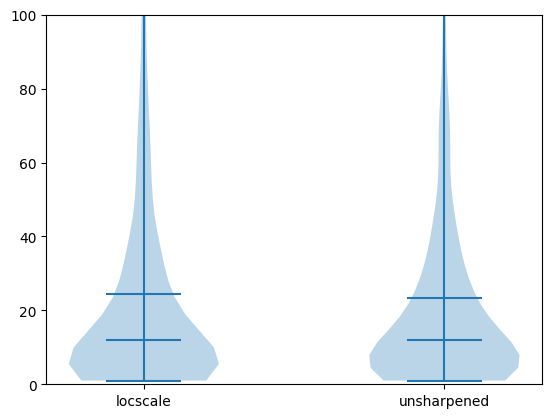

In [108]:
fragment_lengths_using_locscale_all = []
fragment_lengths_using_unsharpened_all = []
for emdb_pdb in residue_lengths_emdb_dict:
    fragment_lengths_using_locscale_all.extend(residue_lengths_emdb_dict[emdb_pdb]["fragment_lengths_using_locscale"])
    fragment_lengths_using_unsharpened_all.extend(residue_lengths_emdb_dict[emdb_pdb]["fragment_lengths_using_unsharpened"])

pvalue_fragments_locscale_unsharpened = get_significance_permutation_test(fragment_lengths_using_locscale_all, fragment_lengths_using_unsharpened_all).pvalue
print("P-value for fragments using locscale vs unsharpened: ", pvalue_fragments_locscale_unsharpened)
plt.violinplot([fragment_lengths_using_locscale_all, fragment_lengths_using_unsharpened_all], showmeans=True, showmedians=True, showextrema=True)
plt.xticks([1, 2], ["locscale", "unsharpened"])
plt.ylim(0, 100)


In [109]:
extra_residues_fragment_when_locscale_is_better = []
extra_residues_fragment_when_unsharpened_is_better = []
for emdb_pdb in residue_lengths_emdb_dict:
    if residue_lengths_emdb_dict[emdb_pdb]["locscale_gt_unsharpened"]:
        extra_residues_fragment_when_locscale_is_better.extend(residue_lengths_emdb_dict[emdb_pdb]["fragment_lengths_extra_residues"])
    else:
        extra_residues_fragment_when_unsharpened_is_better.extend(residue_lengths_emdb_dict[emdb_pdb]["fragment_lengths_extra_residues"])
res = get_significance_permutation_test(extra_residues_fragment_when_locscale_is_better, extra_residues_fragment_when_unsharpened_is_better)
print("P-value for extra residues when locscale is better vs unsharpened: ", res.pvalue)



p-value: 0.019998000199980003
observed statistic: -0.5720809968847353
P-value for extra residues when locscale is better vs unsharpened:  0.019998000199980003


<AxesSubplot:ylabel='Count'>

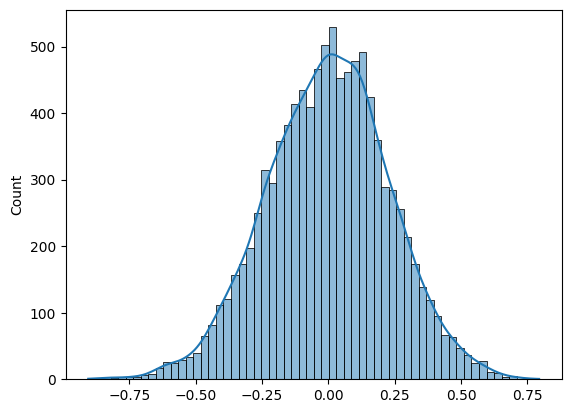

In [110]:
sns.histplot(res.null_distribution, kde=True)

<AxesSubplot:>

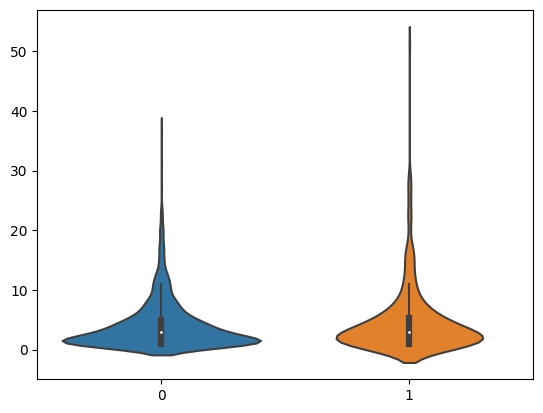

In [111]:
sns.violinplot(data=[extra_residues_fragment_when_locscale_is_better, extra_residues_fragment_when_unsharpened_is_better])
#sns.swarmplot([extra_residues_fragment_when_locscale_is_better, extra_residues_fragment_when_unsharpened_is_better], color="black", alpha=0.1)
#sns.histplot(data=[extra_residues_fragment_when_locscale_is_better, extra_residues_fragment_when_unsharpened_is_better], kde=True, stat="probability", common_norm=False)


p-value: 0.1367863213678632
observed statistic: 117.9090909090909


{'bodies': [<matplotlib.collections.PolyCollection at 0x7fd591f335e0>,
 'cmeans': <matplotlib.collections.LineCollection at 0x7fd58e2142b0>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7fd58dcae1f0>,
 'cmins': <matplotlib.collections.LineCollection at 0x7fd58e214fa0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7fd58dced1c0>,
 'cmedians': <matplotlib.collections.LineCollection at 0x7fd58dced6a0>}

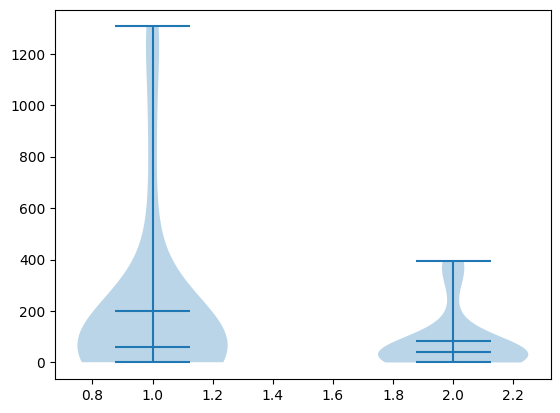

In [112]:
delta_residues_when_locscale_is_better = []
delta_residues_when_unsharpened_is_better = []
for emdb_pdb in residue_lengths_emdb_dict:
    if residue_lengths_emdb_dict[emdb_pdb]["locscale_gt_unsharpened"]:
        delta_residues_when_locscale_is_better.append(residue_lengths_emdb_dict[emdb_pdb]["delta_residues"])
    else:
        delta_residues_when_unsharpened_is_better.append(residue_lengths_emdb_dict[emdb_pdb]["delta_residues"])

res = get_significance_permutation_test(delta_residues_when_locscale_is_better, delta_residues_when_unsharpened_is_better)
plt.violinplot([delta_residues_when_locscale_is_better, delta_residues_when_unsharpened_is_better], showmeans=True, showmedians=True, showextrema=True)

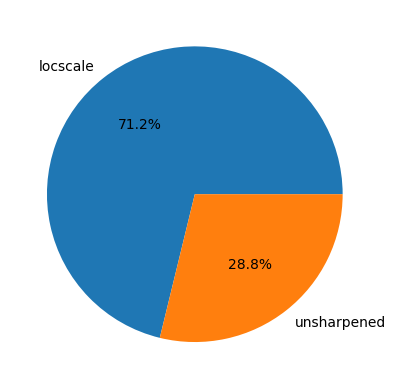

In [113]:
num_fragments_more_than_ten_extra_residues_locscale = len([x for x in extra_residues_fragment_when_locscale_is_better if x > 10])
num_fragments_more_than_ten_extra_residues_unsharpened = len([x for x in extra_residues_fragment_when_unsharpened_is_better if x > 10])
plt.pie([num_fragments_more_than_ten_extra_residues_locscale, num_fragments_more_than_ten_extra_residues_unsharpened], labels=["locscale", "unsharpened"], autopct='%1.1f%%');

(-50.0, 1300.0)

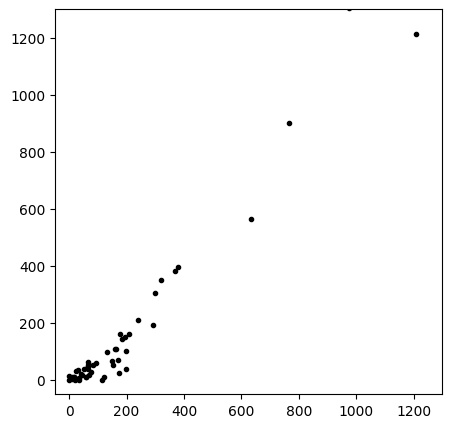

In [114]:
plt.figure(figsize=(5,5))
for emdb_pdb in residue_lengths_emdb_dict:
    plt.plot(residue_lengths_emdb_dict[emdb_pdb]["extracted_extra_residues"], residue_lengths_emdb_dict[emdb_pdb]["delta_residues"], "k.-")
plt.xlim(-50, 1300)
plt.ylim(-50, 1300)
    

/home/abharadwaj1/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/abharadwaj1/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


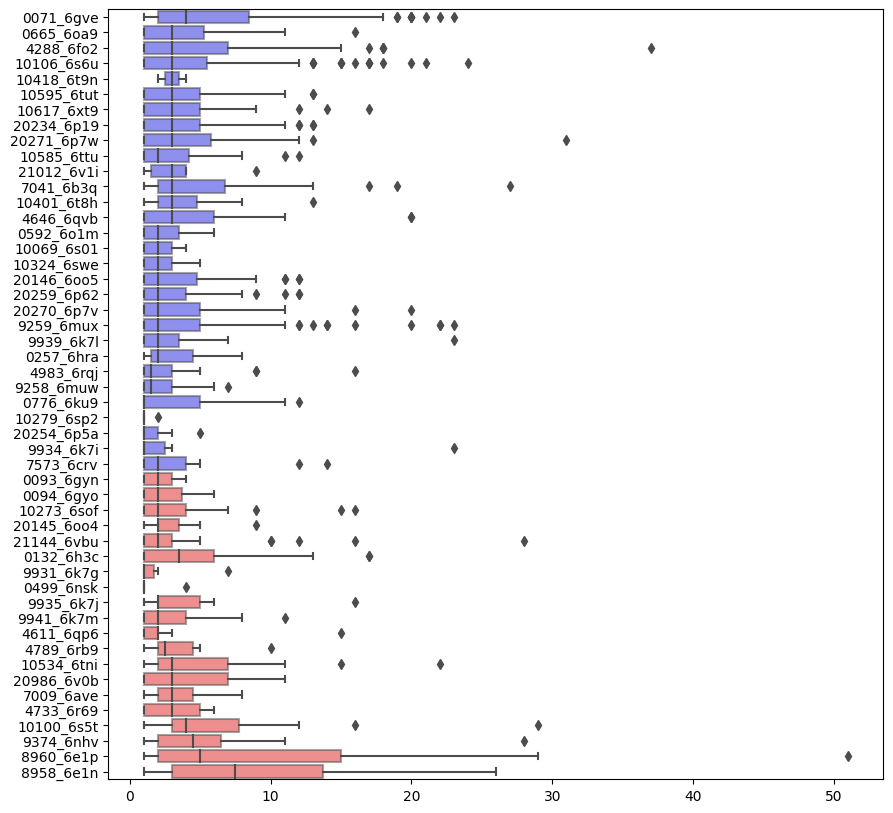

In [115]:
# plot a horizontal box plot of the fragment length distributions
def plot_boxplot_fragment_length_distribution(residue_lengths_emdb_dict, plot_key):
    sorted_keys_blue = {} # for those emdb_pdbs where locscale_gt_unsharpened is True
    sorted_keys_red = {} # for those emdb_pdbs where locscale_gt_unsharpened is False
    
    for emdb_pdb in residue_lengths_emdb_dict:
        median = np.median(residue_lengths_emdb_dict[emdb_pdb][plot_key])
        if residue_lengths_emdb_dict[emdb_pdb]["locscale_gt_unsharpened"]:
            sorted_keys_blue[emdb_pdb] = median
        else:
            sorted_keys_red[emdb_pdb] = median
    
    # sort the keys by median fragment length
    ## sort the blue keys highest to lowest
    sorted_keys_blue = {k: v for k, v in sorted(sorted_keys_blue.items(), key=lambda item: item[1], reverse=True)}
    ## sort the red keys lowest to highest
    sorted_keys_red = {k: v for k, v in sorted(sorted_keys_red.items(), key=lambda item: item[1])}
    
    # combine the two dictionaries into one
    sorted_keys = list(sorted_keys_blue.keys()) + list(sorted_keys_red.keys())
    
    
    fig, ax = plt.subplots(figsize=(10, 10))
    fragment_lengths = []
    emdb_pdb_list = []
    colors = []
    for emdb_pdb in sorted_keys:
        fragment_lengths.extend(residue_lengths_emdb_dict[emdb_pdb][plot_key])
        emdb_pdb_list.extend([emdb_pdb] * len(residue_lengths_emdb_dict[emdb_pdb][plot_key]))
        # color blue if locscale_gt_unsharpened is True, red otherwise
        colors.extend(["blue" if residue_lengths_emdb_dict[emdb_pdb]["locscale_gt_unsharpened"] else "red"])
    
    #sns.stripplot(x=fragment_lengths, y=emdb_pdb_list, ax=ax, orient="h", palette=colors, jitter=0.2, size=4)
    sns.boxplot(x=fragment_lengths, y=emdb_pdb_list, ax=ax, orient="h", palette=colors, whis=1.5, boxprops=dict(alpha=.5))
    
    return fig, ax

fig, ax = plot_boxplot_fragment_length_distribution(residue_lengths_emdb_dict, "fragment_lengths_extra_residues")

In [116]:
len(residue_lengths_emdb_dict)

52

In [117]:
# plot a butterfly plot for the fragment length distributions and difference in number of residues for each emdb_pdb
def plot_butterfly(emdb_pdb_list, residue_delta, length_distribution, left_label, right_label, title):
    fig, ax = plt.subplots(1,2, figsize=(20, 10), subplot_kw={'yticks': []}, gridspec_kw={'wspace': 0.08})

    y = np.arange(len(emdb_pdb_list))
    labels = [x.split("_")[0] for x in emdb_pdb_list]
    
    ax[0].invert_xaxis()    
    ax[0].set_title(left_label)
    ax[1].set_title(right_label)
    
    # plot the difference in number of residues on the left side
    
    #for i in range(len(residue_delta)):
        
    sns.barplot(x=residue_delta, y=y, color="blue", ax=ax[0], orient="h")
    sns.boxplot(x=length_distribution, y=y, color="blue", ax=ax[1], orient="h", whis=1.5, boxprops=dict(alpha=.5))

    # place the y ticks and labels in the middle of the two plots
    ax[1].set_yticks(y)
    ax[1].set_yticklabels(labels)
    
    
    return fig, ax  

In [118]:
def get_residue_statistics(reference_structure, target_structure,search_dist=3):
    
    reference_residues = get_all_residues(reference_structure)[0]
    target_residues = get_all_residues(target_structure)[0]
    
    reference_residues = filter_residue_sequence(reference_residues)
    target_residues = filter_residue_sequence(target_residues)
    
    ns_reference = gemmi.NeighborSearch(reference_structure[0], reference_structure.cell, search_dist).populate()
    ns_target = gemmi.NeighborSearch(target_structure[0], target_structure.cell, search_dist).populate()
    
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    
    for residue in reference_residues:
        closest_residue = find_closest_residue(residue, target_structure, ns_target, search_dist=3)
        if isinstance(closest_residue, gemmi.Residue):
            target_residue_reverse = find_closest_residue(closest_residue, reference_structure, ns_reference, search_dist=3)
            if target_residue_reverse.name == residue.name:
                true_positives += 1
        else:
            false_negatives += 1
    
    for residue in target_residues:
        closest_residue = find_closest_residue(residue, reference_structure, ns_reference, search_dist=3)
        if not isinstance(closest_residue, gemmi.Residue):
            false_positives += 1

    return true_positives, false_positives, false_negatives
        



In [119]:
def get_extra_residues_length_distribution(emdb_pdb):
    emdb, pdb = emdb_pdb.split("_")
    suffix = ""
    pdb_path_1 = f"/home/abharadwaj1/papers/elife_paper/figure_information/data/model_angelo_predictions_new_version/{emdb_pdb}/emd_{emdb}_model_angelo_unsharpened/emd_{emdb}_model_angelo_unsharpened{suffix}.cif"
    pdb_path_2 = f"/home/abharadwaj1/papers/elife_paper/figure_information/data/model_angelo_predictions_new_version/{emdb_pdb}/emd_{emdb}_model_angelo_hybrid/emd_{emdb}_model_angelo_hybrid{suffix}.cif"

    search_radius=3

In [120]:
recall_rates_hybrid = []
recall_rates_unsharpened = []

precision_rates_hybrid = []
precision_rates_unsharpened = []

for emdb_pdb in os.listdir(model_angelo_prediction_dir):
    emdb, pdb = emdb_pdb.split("_")
    suffix = ""
    pdb_path_1 = f"/home/abharadwaj1/papers/elife_paper/figure_information/data/model_angelo_predictions_new_version/{emdb_pdb}/emd_{emdb}_model_angelo_unsharpened/emd_{emdb}_model_angelo_unsharpened{suffix}.cif"
    pdb_path_2 = f"/home/abharadwaj1/papers/elife_paper/figure_information/data/model_angelo_predictions_new_version/{emdb_pdb}/emd_{emdb}_model_angelo_hybrid/emd_{emdb}_model_angelo_hybrid{suffix}.cif"
    reference_pdb_path = f"/home/abharadwaj1/papers/elife_paper/figure_information/data/deposited_atomic_models/PDB_{pdb}_unrefined_shifted_servalcat_refined_shifted_servalcat_refined.pdb"
    
    if not os.path.exists(pdb_path_1) or not os.path.exists(pdb_path_2) or not os.path.exists(reference_pdb_path):
        continue
    st_1 = gemmi.read_structure(pdb_path_1)
    st_2 = gemmi.read_structure(pdb_path_2)
    st_ref = gemmi.read_structure(reference_pdb_path)
    
    tp_unsharpened, fp_unsharpened, fn_unsharpened = get_residue_statistics(st_1, st_ref)
    tp_hybrid, fp_hybrid, fn_hybrid = get_residue_statistics(st_2, st_ref)
    
    recall_unsharp = tp_unsharpened/(tp_unsharpened+fn_unsharpened)
    recall_hybrid = tp_hybrid/(tp_hybrid+fn_hybrid)
    
    recall_rates_unsharpened.append(recall_unsharp)
    recall_rates_hybrid.append(recall_hybrid)
    
    precision_unsharp = tp_unsharpened/(tp_unsharpened+fp_unsharpened)
    precision_hybrid = tp_hybrid/(tp_hybrid+fp_hybrid)
    
    precision_rates_unsharpened.append(precision_unsharp)
    precision_rates_hybrid.append(precision_hybrid)
    

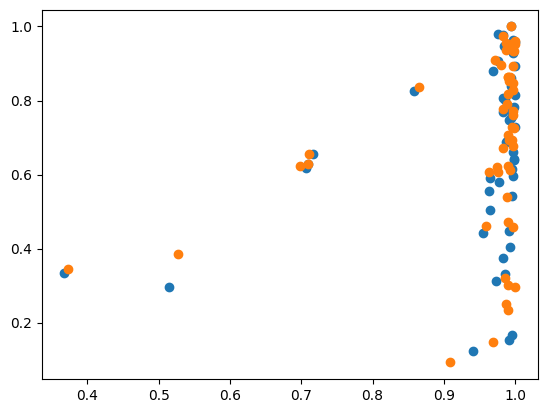

In [121]:
plt.plot(recall_rates_unsharpened, precision_rates_unsharpened, "o", label="Unsharpened")
plt.plot(recall_rates_hybrid, precision_rates_hybrid, "o", label="Hybrid")

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (52,) + inhomogeneous part.

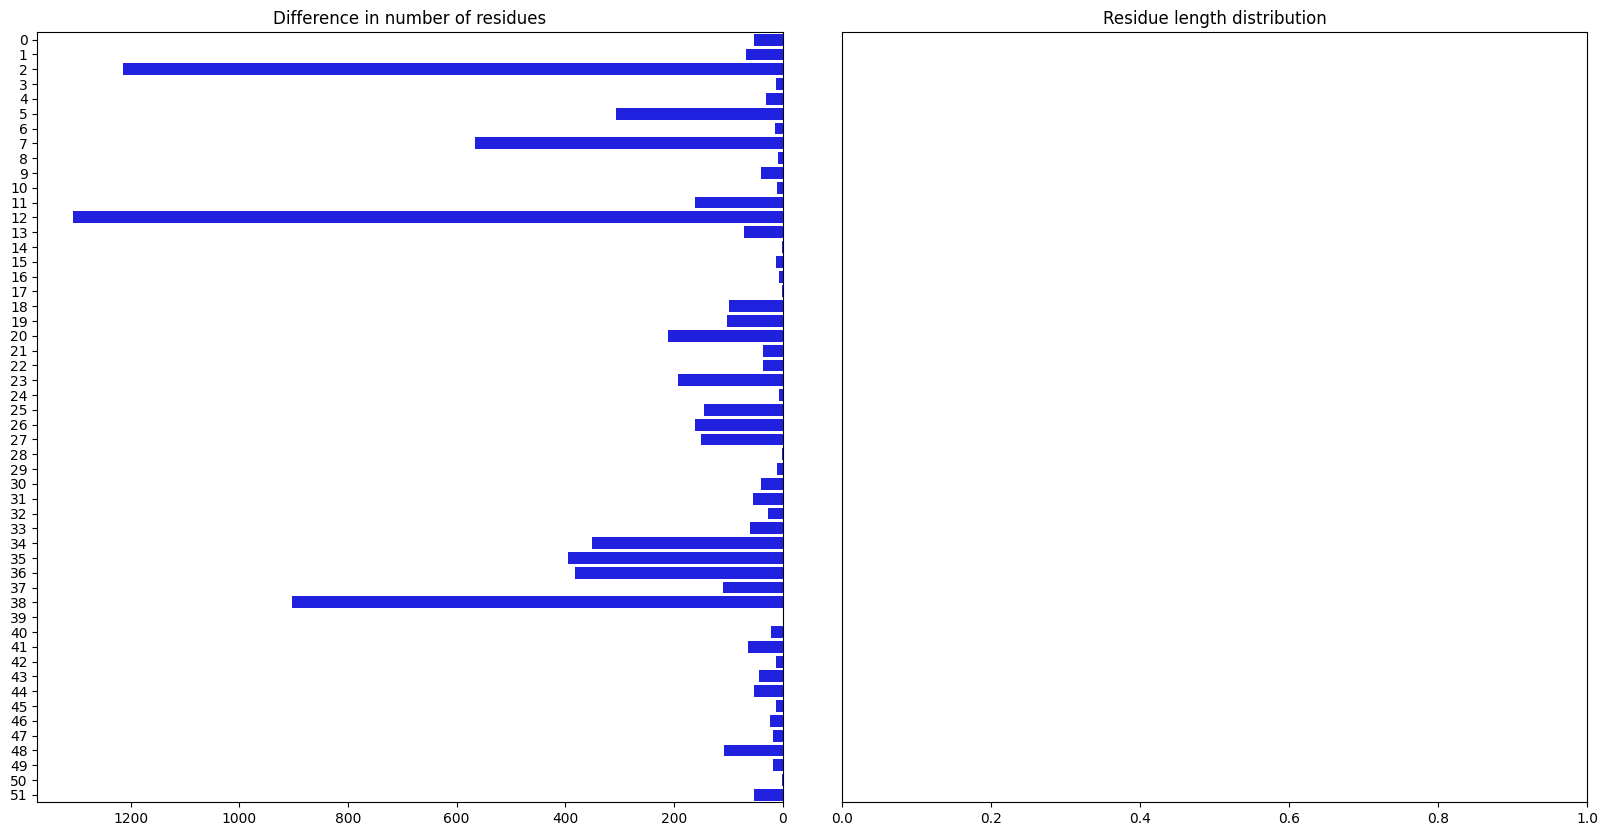

In [122]:
emdb_pdb_list = list(residue_lengths_emdb_dict.keys())
left_array = [residue_lengths_emdb_dict[emdb_pdb]["delta_residues"] for emdb_pdb in emdb_pdb_list]
right_array = [residue_lengths_emdb_dict[emdb_pdb]["fragment_lengths_extra_residues"] for emdb_pdb in emdb_pdb_list]
left_label = "Difference in number of residues"
right_label = "Residue length distribution"
title_text = "Difference in number of residues (top)"

r = plot_butterfly(emdb_pdb_list, left_array, right_array, left_label, right_label, title_text);

In [ ]:
len(residue_lengths_emdb_dict)

53

In [ ]:
emdb_pdb_from_emdb = {x.split("_")[0]: x for x in os.listdir(model_angelo_prediction_dir)}
np.median(residue_lengths_emdb_dict[emdb_pdb_from_emdb["9939"]]["fragment_lengths_extra_residues"])